# Exercise 3

### 1 Introduction

Epoch: 0
Mean Train Loss: 3.96e-01
Mean Test Loss:  1.65e-01
Epoch: 10
Mean Train Loss: 1.62e-01
Mean Test Loss:  2.45e-01
Epoch: 20
Mean Train Loss: 1.04e-01
Mean Test Loss:  4.59e-01
Epoch: 30
Mean Train Loss: 7.35e-02
Mean Test Loss:  4.95e-01
Epoch: 40
Mean Train Loss: 5.48e-02
Mean Test Loss:  6.25e-01
Epoch: 50
Mean Train Loss: 4.58e-02
Mean Test Loss:  6.82e-01
Epoch: 60
Mean Train Loss: 2.86e-02
Mean Test Loss:  8.56e-01
Epoch: 70
Mean Train Loss: 2.53e-02
Mean Test Loss:  1.13e+00
Epoch: 80
Mean Train Loss: 2.44e-02
Mean Test Loss:  1.21e+00
Epoch: 90
Mean Train Loss: 1.60e-02
Mean Test Loss:  1.10e+00
Epoch: 100
Mean Train Loss: 1.49e-02
Mean Test Loss:  1.00e+00


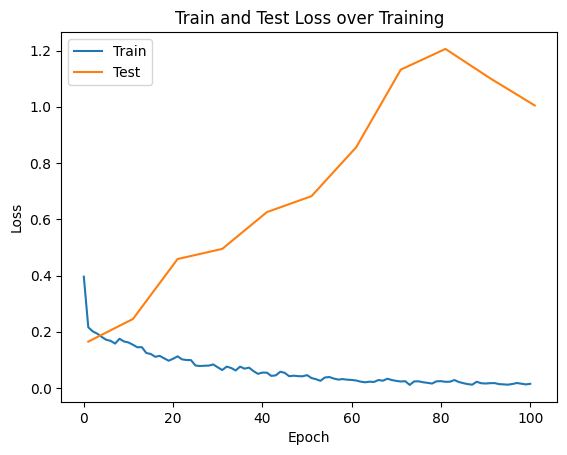

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


### 2 Dropout

Epoch: 0
Mean Train Loss: 5.15e-01
Mean Test Loss:  1.73e-01
Epoch: 10
Mean Train Loss: 3.82e-01
Mean Test Loss:  2.23e-01
Epoch: 20
Mean Train Loss: 4.03e-01
Mean Test Loss:  2.67e-01
Epoch: 30
Mean Train Loss: 4.17e-01
Mean Test Loss:  2.43e-01
Epoch: 40
Mean Train Loss: 4.12e-01
Mean Test Loss:  4.20e-01
Epoch: 50
Mean Train Loss: 4.47e-01
Mean Test Loss:  4.79e-01
Epoch: 60
Mean Train Loss: 4.48e-01
Mean Test Loss:  4.82e-01
Epoch: 70
Mean Train Loss: 4.67e-01
Mean Test Loss:  5.42e-01
Epoch: 80
Mean Train Loss: 4.50e-01
Mean Test Loss:  6.08e-01
Epoch: 90
Mean Train Loss: 4.84e-01
Mean Test Loss:  5.01e-01
Epoch: 100
Mean Train Loss: 4.39e-01
Mean Test Loss:  7.90e-01


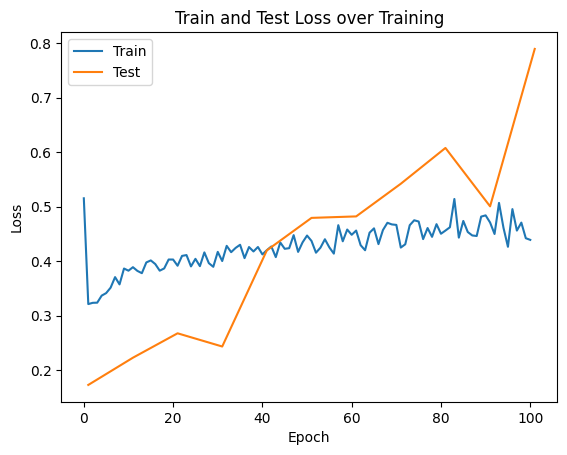

In [2]:
def dropout(X_input, p_drop:float):
    mat_rand = torch.rand(X_input.shape)
    return torch.where(mat_rand < p_drop, 0, X_input / (1-p_drop))

def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    h = rectify(dropout(X, p_drop_input) @ w_h)
    
    h2 = rectify(dropout(h, p_drop_hidden) @ w_h2)
    
    pre_softmax = dropout(h2, p_drop_hidden) @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0.05, 0.3)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0.0, 0.0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


The dropout method works by disabling a few, randomly selected neurons in the input and hidden layers. Here, 5% of the input neurons and 30% of the hidden neurons are dropped.
This forces the network to learn more robust representations instead of memorizing the training set.

For the test loss we want to test the full power of the network and therefore don't want any neurons to be dropped.

Dropout reduces the cross-entropy loss after 100 epochs from 1 to 0.8. The graph is also less steep than without dropout, so it is a step in the right direction. However, the model is not yet strong enough to actually perform well.

### 3 Parametric Relu

Epoch: 0
Mean Train Loss: 5.37e-01
Mean Test Loss:  1.74e-01
Epoch: 10
Mean Train Loss: 2.15e-01
Mean Test Loss:  1.47e-01
Epoch: 20
Mean Train Loss: 1.99e-01
Mean Test Loss:  1.75e-01
Epoch: 30
Mean Train Loss: 1.81e-01
Mean Test Loss:  1.53e-01
Epoch: 40
Mean Train Loss: 1.72e-01
Mean Test Loss:  1.55e-01
Epoch: 50
Mean Train Loss: 1.66e-01
Mean Test Loss:  1.43e-01
Epoch: 60
Mean Train Loss: 1.49e-01
Mean Test Loss:  1.37e-01
Epoch: 70
Mean Train Loss: 1.44e-01
Mean Test Loss:  1.74e-01
Epoch: 80
Mean Train Loss: 1.36e-01
Mean Test Loss:  2.07e-01
Epoch: 90
Mean Train Loss: 1.43e-01
Mean Test Loss:  1.57e-01
Epoch: 100
Mean Train Loss: 1.29e-01
Mean Test Loss:  1.78e-01


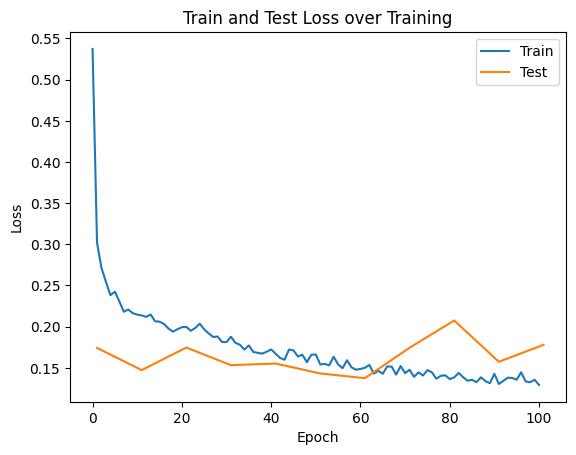

In [24]:
def PRelu(X_input, a_input):
    a_exp = a_input.expand(-1, X_input.shape[0]).transpose(0, 1)
    return torch.where(X_input <= 0, X_input*a_exp, X_input)


def init_prelu(shape):
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def prelu_dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    h = PRelu(dropout(X, p_drop_input) @ w_h, prelu_h)

    h2 = PRelu(dropout(h, p_drop_hidden) @ w_h2, prelu_h2)

    pre_softmax = dropout(h2, p_drop_hidden) @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

#init PRelu
prelu_h = init_prelu((625,1))
prelu_h2 = init_prelu((625,1))


optimizer = RMSprop(params=[w_h, w_h2, w_o, prelu_h, prelu_h2])

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = prelu_dropout_model(x, w_h, w_h2, w_o, 0.05, 0.3)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = prelu_dropout_model(x, w_h, w_h2, w_o, 0.0, 0.0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

With PRelu the test loss is reduced from 0.8 to 0.178 after 100 epochs which is a big improvement. Still, tendencies of overfitting can be found after epoch 60.

### 4 Convolutional layers

### 4.1 Create a Convolutional network

Epoch: 0
Mean Train Loss: 1.38e+00
Mean Test Loss:  1.84e-01
Epoch: 10
Mean Train Loss: 1.79e-01
Mean Test Loss:  5.77e-02
Epoch: 20
Mean Train Loss: 1.71e-01
Mean Test Loss:  6.06e-02
Epoch: 30
Mean Train Loss: 1.73e-01
Mean Test Loss:  6.30e-02
Epoch: 40
Mean Train Loss: 1.79e-01
Mean Test Loss:  7.61e-02
Epoch: 50
Mean Train Loss: 1.89e-01
Mean Test Loss:  7.59e-02
Epoch: 60
Mean Train Loss: 1.97e-01
Mean Test Loss:  6.68e-02
Epoch: 70
Mean Train Loss: 1.91e-01
Mean Test Loss:  1.09e-01
Epoch: 80
Mean Train Loss: 1.92e-01
Mean Test Loss:  7.51e-02
Epoch: 90
Mean Train Loss: 1.84e-01
Mean Test Loss:  1.15e-01
Epoch: 100
Mean Train Loss: 1.92e-01
Mean Test Loss:  9.20e-02


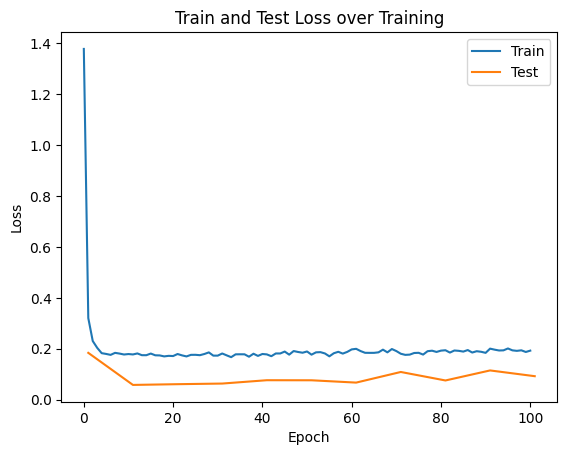

In [73]:
from torch.nn.functional import conv2d, max_pool2d

def cnn_model(X_input, w_conv1_in, w_conv2_in, w_conv3_in, w_h2_in, w_o_in, p_drop_input,  p_drop_hidden):

    # Convolutional Layer 1
    convolutional_layer1 = rectify(conv2d(X_input, w_conv1_in))
    subsampling_layer1 = max_pool2d(convolutional_layer1 , (2, 2))
    out_layer1 = dropout(subsampling_layer1 , p_drop_input)
    
    # Convolutional Layer 2
    convolutional_layer2 = rectify(conv2d(out_layer1, w_conv2_in))
    subsampling_layer2 = max_pool2d(convolutional_layer2 , (2, 2))
    out_layer2 = dropout(subsampling_layer2 , p_drop_input)
    
    # Convolutional Layer 3
    convolutional_layer3 = rectify(conv2d(out_layer2, w_conv3_in))
    subsampling_layer3 = max_pool2d(convolutional_layer3 , (2, 2))
    out_layer3 = dropout(subsampling_layer3 , p_drop_input)
    
    out_layer3_flat = out_layer3.reshape(100, 128)

    h2 = PRelu(dropout(out_layer3_flat, p_drop_hidden) @ w_h2_in, prelu_h2)

    pre_softmax = dropout(h2, p_drop_hidden) @ w_o_in

    # Save state of the first convolutional layer here as function attribute to output it in 4.2
    cnn_model.conv_matrix_layer1 = convolutional_layer1
    cnn_model.conv_weights_layer1 = w_conv1_in
    
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_conv1 = init_weights((32, 1, 5, 5))
w_conv2 = init_weights((64, 32, 5, 5))
w_conv3 = init_weights((128, 64, 3, 3))
# 3 Convolutional Layers
# number_of_output_pixel = 1 * 1 * 128
w_h2 = init_weights((128, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

#init PRelu
prelu_h2 = init_prelu((625,1))


optimizer = RMSprop(params=[w_conv1, w_conv2, w_conv3, w_h2, w_o, prelu_h2])

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        trainX = x.reshape(-1, 1, 28, 28) #training data
        # feed input through model
        noise_py_x = cnn_model(trainX, w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.05, 0.3)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                testX = x.reshape(-1, 1, 28, 28) #test data
                
                noise_py_x = cnn_model(testX, w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.0, 0.0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Test loss reduced to 0.092 and training is basically finished after just 5 epochs.

### 4.2 Application of Convolutional network

Second image from the test set:


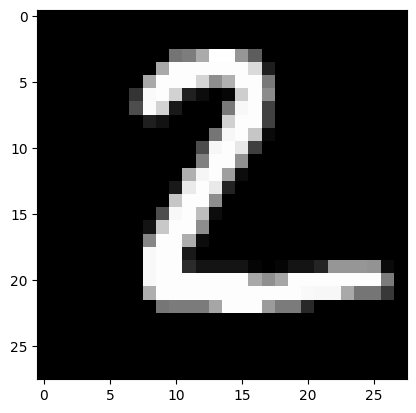

In [102]:
print("Second image from the test set:")

images, labels = next(iter(test_dataloader))
img = np.array(images[1].reshape(28,28))
plt.figure()
plt.imshow(img, interpolation="nearest")
plt.show()


Weight matrix of filter 2:
 tensor([[[ 0.1626, -0.0426, -0.1847, -0.0042,  0.0396],
         [-0.3434, -0.2685,  0.4383, -0.0479, -0.0324],
         [ 0.0289,  0.3023, -0.0233, -0.1427,  0.0348],
         [ 0.0034, -0.2009, -0.1256, -0.0053,  0.0269],
         [ 0.0118,  0.0325, -0.0321,  0.0911, -0.1139]]],
       grad_fn=<SelectBackward0>) 

Weight matrix of filter 4:
 tensor([[[ 0.0148, -0.0190,  0.0046, -0.0305,  0.0395],
         [ 0.0448, -0.0309, -0.0171, -0.0160,  0.0313],
         [ 0.0299, -0.0435,  0.0110, -0.0055,  0.0230],
         [ 0.0324, -0.0226, -0.0182, -0.0167,  0.0283],
         [ 0.0127, -0.0062,  0.0144, -0.0124,  0.0204]]],
       grad_fn=<SelectBackward0>) 

Weight matrix of filter 26:
 tensor([[[ 0.0211,  0.0169, -0.0038,  0.0007,  0.0095],
         [-0.0217, -0.0179,  0.0396, -0.0589,  0.0204],
         [-0.0089,  0.0097, -0.0042,  0.0249, -0.0648],
         [ 0.0039,  0.0043, -0.0193, -0.0036, -0.0006],
         [ 0.0033,  0.0130, -0.0129, -0.0120,  0.0077]]

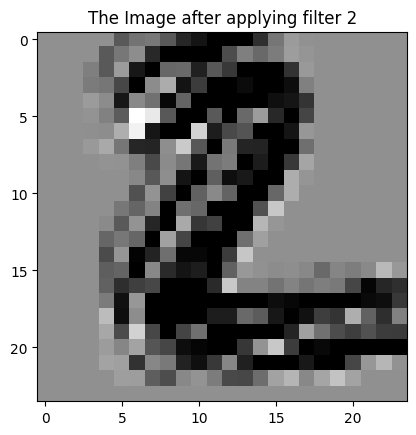

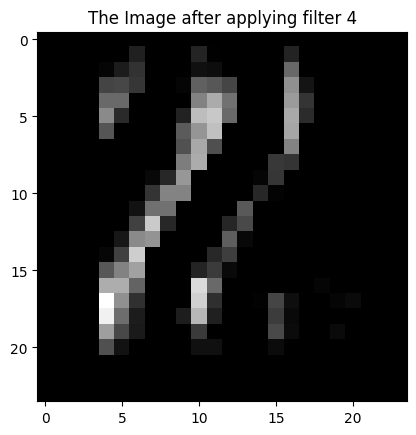

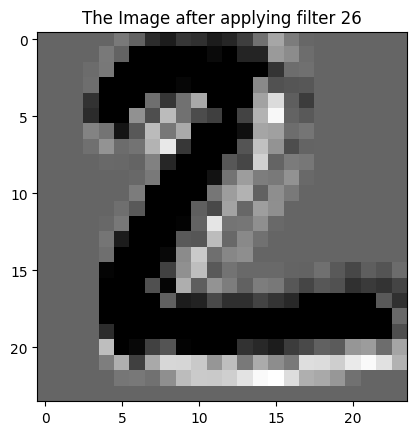

In [97]:
convolution_layer1 = cnn_model.conv_matrix_layer1
convolution_layer1_weights = cnn_model.conv_weights_layer1

images_conv = rectify(conv2d(images[1].reshape(1, 1, 28, 28), convolution_layer1_weights)).detach().numpy()

img_conv1 = images_conv[0][1]
img_conv2 = images_conv[0][3]
img_conv3 = images_conv[0][25]

print(f"Weight matrix of filter 2:\n {convolution_layer1_weights[1]} \n")
print(f"Weight matrix of filter 4:\n {convolution_layer1_weights[3]} \n")
print(f"Weight matrix of filter 26:\n {convolution_layer1_weights[25]} \n")

plt.figure()

plt.title("The Image after applying filter 2")
plt.imshow(img_conv1, interpolation="nearest")
plt.show()

plt.title("The Image after applying filter 4")
plt.imshow(img_conv2, interpolation="nearest")
plt.show()

plt.title("The Image after applying filter 26")
plt.imshow(img_conv3, interpolation="nearest")
plt.show()


### Additional task: Add or remove one convolutional layer

Added a fourth convolutional layer and adjusted the kernel sizes a bit.

Epoch: 0
Mean Train Loss: 4.01e+00
Mean Test Loss:  7.92e-01
Epoch: 10
Mean Train Loss: 2.95e-01
Mean Test Loss:  1.17e-01
Epoch: 20
Mean Train Loss: 2.90e-01
Mean Test Loss:  1.65e-01
Epoch: 30
Mean Train Loss: 2.93e-01
Mean Test Loss:  9.80e-02
Epoch: 40
Mean Train Loss: 3.08e-01
Mean Test Loss:  1.12e-01
Epoch: 50
Mean Train Loss: 3.18e-01
Mean Test Loss:  1.05e-01


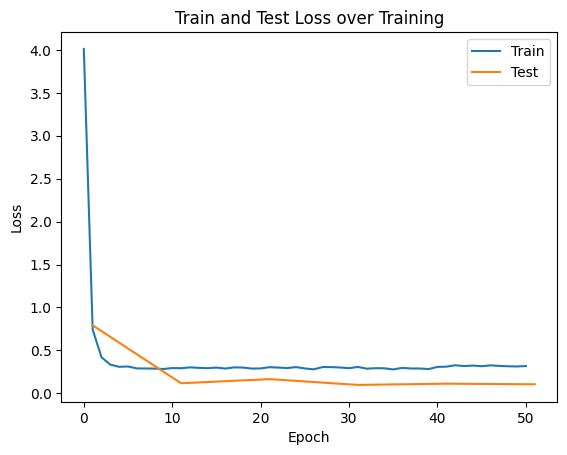

In [101]:
def cnn_v2_model(X_input, w_conv1_in, w_conv2_in, w_conv3_in, w_conv4_in, w_h2_in, w_o_in, p_drop_input,  p_drop_hidden):

    # Convolutional Layer 1
    convolutional_layer1 = rectify(conv2d(X_input, w_conv1_in))
    subsampling_layer1 = max_pool2d(convolutional_layer1 , (2, 2), stride=2)
    out_layer1 = dropout(subsampling_layer1 , p_drop_input)

    # Convolutional Layer 2
    convolutional_layer2 = rectify(conv2d(out_layer1, w_conv2_in))
    subsampling_layer2 = max_pool2d(convolutional_layer2 , (2, 2), stride=1)
    out_layer2 = dropout(subsampling_layer2 , p_drop_input)

    # Convolutional Layer 3
    convolutional_layer3 = rectify(conv2d(out_layer2, w_conv3_in))
    subsampling_layer3 = max_pool2d(convolutional_layer3 , (2, 2), stride=1)
    out_layer3 = dropout(subsampling_layer3 , p_drop_input)

    # Convolutional Layer 4
    convolutional_layer4 = rectify(conv2d(out_layer3, w_conv4_in))
    subsampling_layer4 = max_pool2d(convolutional_layer4 , (2, 2), stride=1)
    out_layer4 = dropout(subsampling_layer4 , p_drop_input)
    
    out_layer4_flat = out_layer4.reshape(100, 256)

    h2 = PRelu(dropout(out_layer4_flat, p_drop_hidden) @ w_h2_in, prelu_h2)

    pre_softmax = dropout(h2, p_drop_hidden) @ w_o_in

    # Save state of the first convolutional layer here as function attribute to output it in 4.2
    cnn_model.conv_matrix_layer1 = convolutional_layer1
    cnn_model.conv_weights_layer1 = w_conv1_in

    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_conv1 = init_weights((32, 1, 4, 4))
w_conv2 = init_weights((32, 32, 4, 4))
w_conv3 = init_weights((64, 32, 3, 3))
w_conv4 = init_weights((64, 64, 3, 3))
# 3 Convolutional Layers
w_h2 = init_weights((256, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

#init PRelu
prelu_h2 = init_prelu((625,1))

optimizer = RMSprop(params=[w_conv1, w_conv2, w_conv3, w_conv4, w_h2, w_o, prelu_h2])

train_loss = []
test_loss = []

# put this into a training loop over 50 epochs
n_epochs = 50
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        trainX = x.reshape(-1, 1, 28, 28) #training data
        # feed input through model
        noise_py_x = cnn_v2_model(trainX, w_conv1, w_conv2, w_conv3, w_conv4, w_h2, w_o, 0.05, 0.3)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                testX = x.reshape(-1, 1, 28, 28) #test data

                noise_py_x = cnn_v2_model(testX, w_conv1, w_conv2, w_conv3, w_conv4, w_h2, w_o, 0.0, 0.0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Additional convolution layer did not improve the model. Test loss increased from 0.0759 to 0.105 after 50 epochs.

### Overview table:

| Section                       | Test Loss |
|-------------------------------|-----------|
| 1 Basic neural net            | 1.000     |
| 2 Dropout                     | 0.800     |
| 3 Prelu                       | 0.178     |
| 4 Convolutional net           | 0.092     |
| 4.2 Conv net with extra layer | 0.105     |